# Mask RCNN Implementation

## Preprocessing data for Mask RCNN

In [1]:
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_DIR = "E:/Kaggle/VinBigData/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = 'C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/converted_data/train/filtered_data/'

In [4]:
orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

### Helper functions for converting bounding boxes to the right format for Mask RCNN

In [5]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    return img_mask.astype(np.float32)
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

### Function convert DICOM data to np.array


In [6]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data


### Load data

#### Load img and encoded label data

In [7]:
training_df = pd.read_csv('C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/converted_data/train/filtered_data/sample_df.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})

In [8]:
samples_df = training_df
samples_df

,image_id,CategoryId,EncodedPixels,Height,Width
0,1c32170b4af4ce1a3030eb8167753b06,[11],[64573 12 65085 12 65597 12 66109 12 66621 12 ...,512,512
1,347180362348e522905047dde655b6d7,[11],[148011 13 148523 13 149035 13 149547 13 15005...,512,512
2,b42e930c16c0166dbeae813b47bb8b07,"[11, 13]",[168516 29 169028 29 169540 29 170052 29 17056...,512,512
3,2d063af5457785f5c76ae1e6c06c0037,"[11, 11]",[146502 21 147014 21 147526 21 148038 21 14855...,512,512
4,231a4b73de5ac7e0218f736b6b6ff1f2,[11],[92233 10 92745 10 93257 10 93769 10 94281 10 ...,512,512
...,...,...,...,...,...
1045,f25a910b0e75a30296bb0350b2a648bd,"[10, 12]",[29885 168 30397 168 30909 168 31421 168 31933...,512,512
1046,d1bcef094e9b8c86c70192220b8e1648,[12],[182860 125 183372 125 183884 125 184396 125 1...,512,512
1047,f3e804892343e3b12e2542939d9101a6,"[10, 12]",[46777 97 47289 97 47801 97 48313 97 48825 97 ...,512,512
1048,4e3a3b03cf00a9060ac139f57843a241,[12],[157254 87 157766 87 158278 87 158790 87 15930...,512,512


## Implement Mask RCNN

In [9]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [10]:
NUM_CATS = 14
IMAGE_SIZE = 512

In [11]:
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7
    # STEPS_PER_EPOCH should be the number of instances
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [12]:
category_list = orin_df.class_name.unique()

In [13]:
category_list

array(['Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD',
       'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis',
       'Other lesion', 'Infiltration', 'Pleural effusion',
       'Calcification', 'Consolidation', 'Pneumothorax'], dtype=object)

In [14]:
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".jpg",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

In [15]:
training_percentage = 0.9

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((1-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

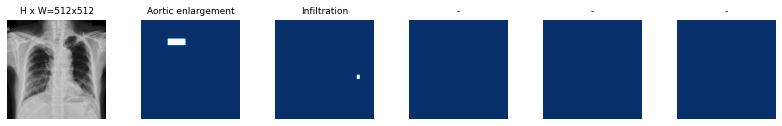

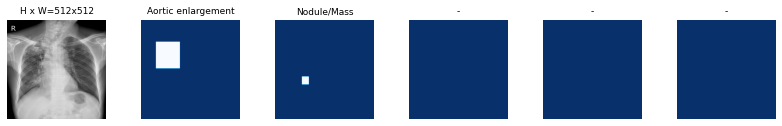

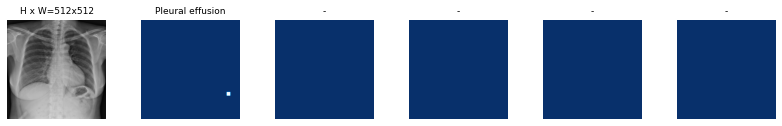

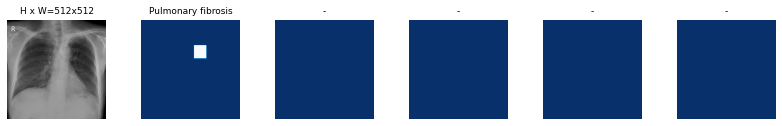

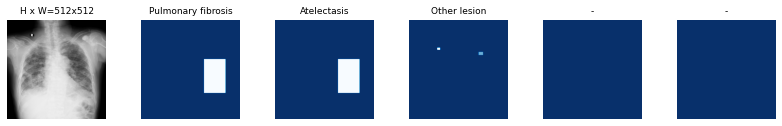

In [16]:
for i in range(0,5):
    image_id = random.choice(train_dataset.image_ids)
    # print(image_id)
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)

    
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

In [17]:
WEIGHT_PATH = 'C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/weights/mask_rcnn_coco.h5'

In [24]:
LR = 1e-3
EPOCHS = 15

model = modellib.MaskRCNN(mode='training', config=config, model_dir="")

model.load_weights(WEIGHT_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [25]:
history = model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: diagnostic20210113T1237\mask_rcnn_diagnostic_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

### Plot history loss evolution

## Submission


In [62]:
model_path = 'C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/diagnostic20210113T1047/mask_rcnn_diagnostic_0015.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 15


In [26]:
PREPROCESSING_TEST_DATA = "C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/converted_data/test/"

In [27]:
class InferenceConfig(DiagnosticConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.5

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir="")


In [23]:
model_path = 'C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/diagnostic20210113T1047/mask_rcnn_diagnostic_0015.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 15


In [28]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon


# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width)).T

def annotations_to_mask(annotations, height, width):
    if isinstance(annotations, list):
        # The annotation consists in a list of RLE codes
        mask = np.zeros((height, width, len(annotations)))
        for i, rle_code in enumerate(annotations):
            mask[:, :, i] = decode_rle(rle_code, height, width)
    else:
        error_message = "{} is expected to be a list or str but received {}".format(annotation, type(annotation))
        raise TypeError(error_message)
    return mask

def find_anomalies(dicom_image, display=False):

    image_dimensions = dicom_image.shape

    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    saved_filename = PREPROCESSING_TEST_DATA+"temp_image.jpg"
    cv2.imwrite(saved_filename, resized_img)
    img = cv2.imread(saved_filename)

#     print(img)
    result = model.detect([img])
    r = result[0]

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'),
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']

    if display:
        visualize.display_instances(img, rois, masks, r['class_ids'],
                                    ['bg']+category_list, r['scores'],
                                    title="prediction", figsize=(12, 12))
    return rois, r['class_ids'], r['scores']

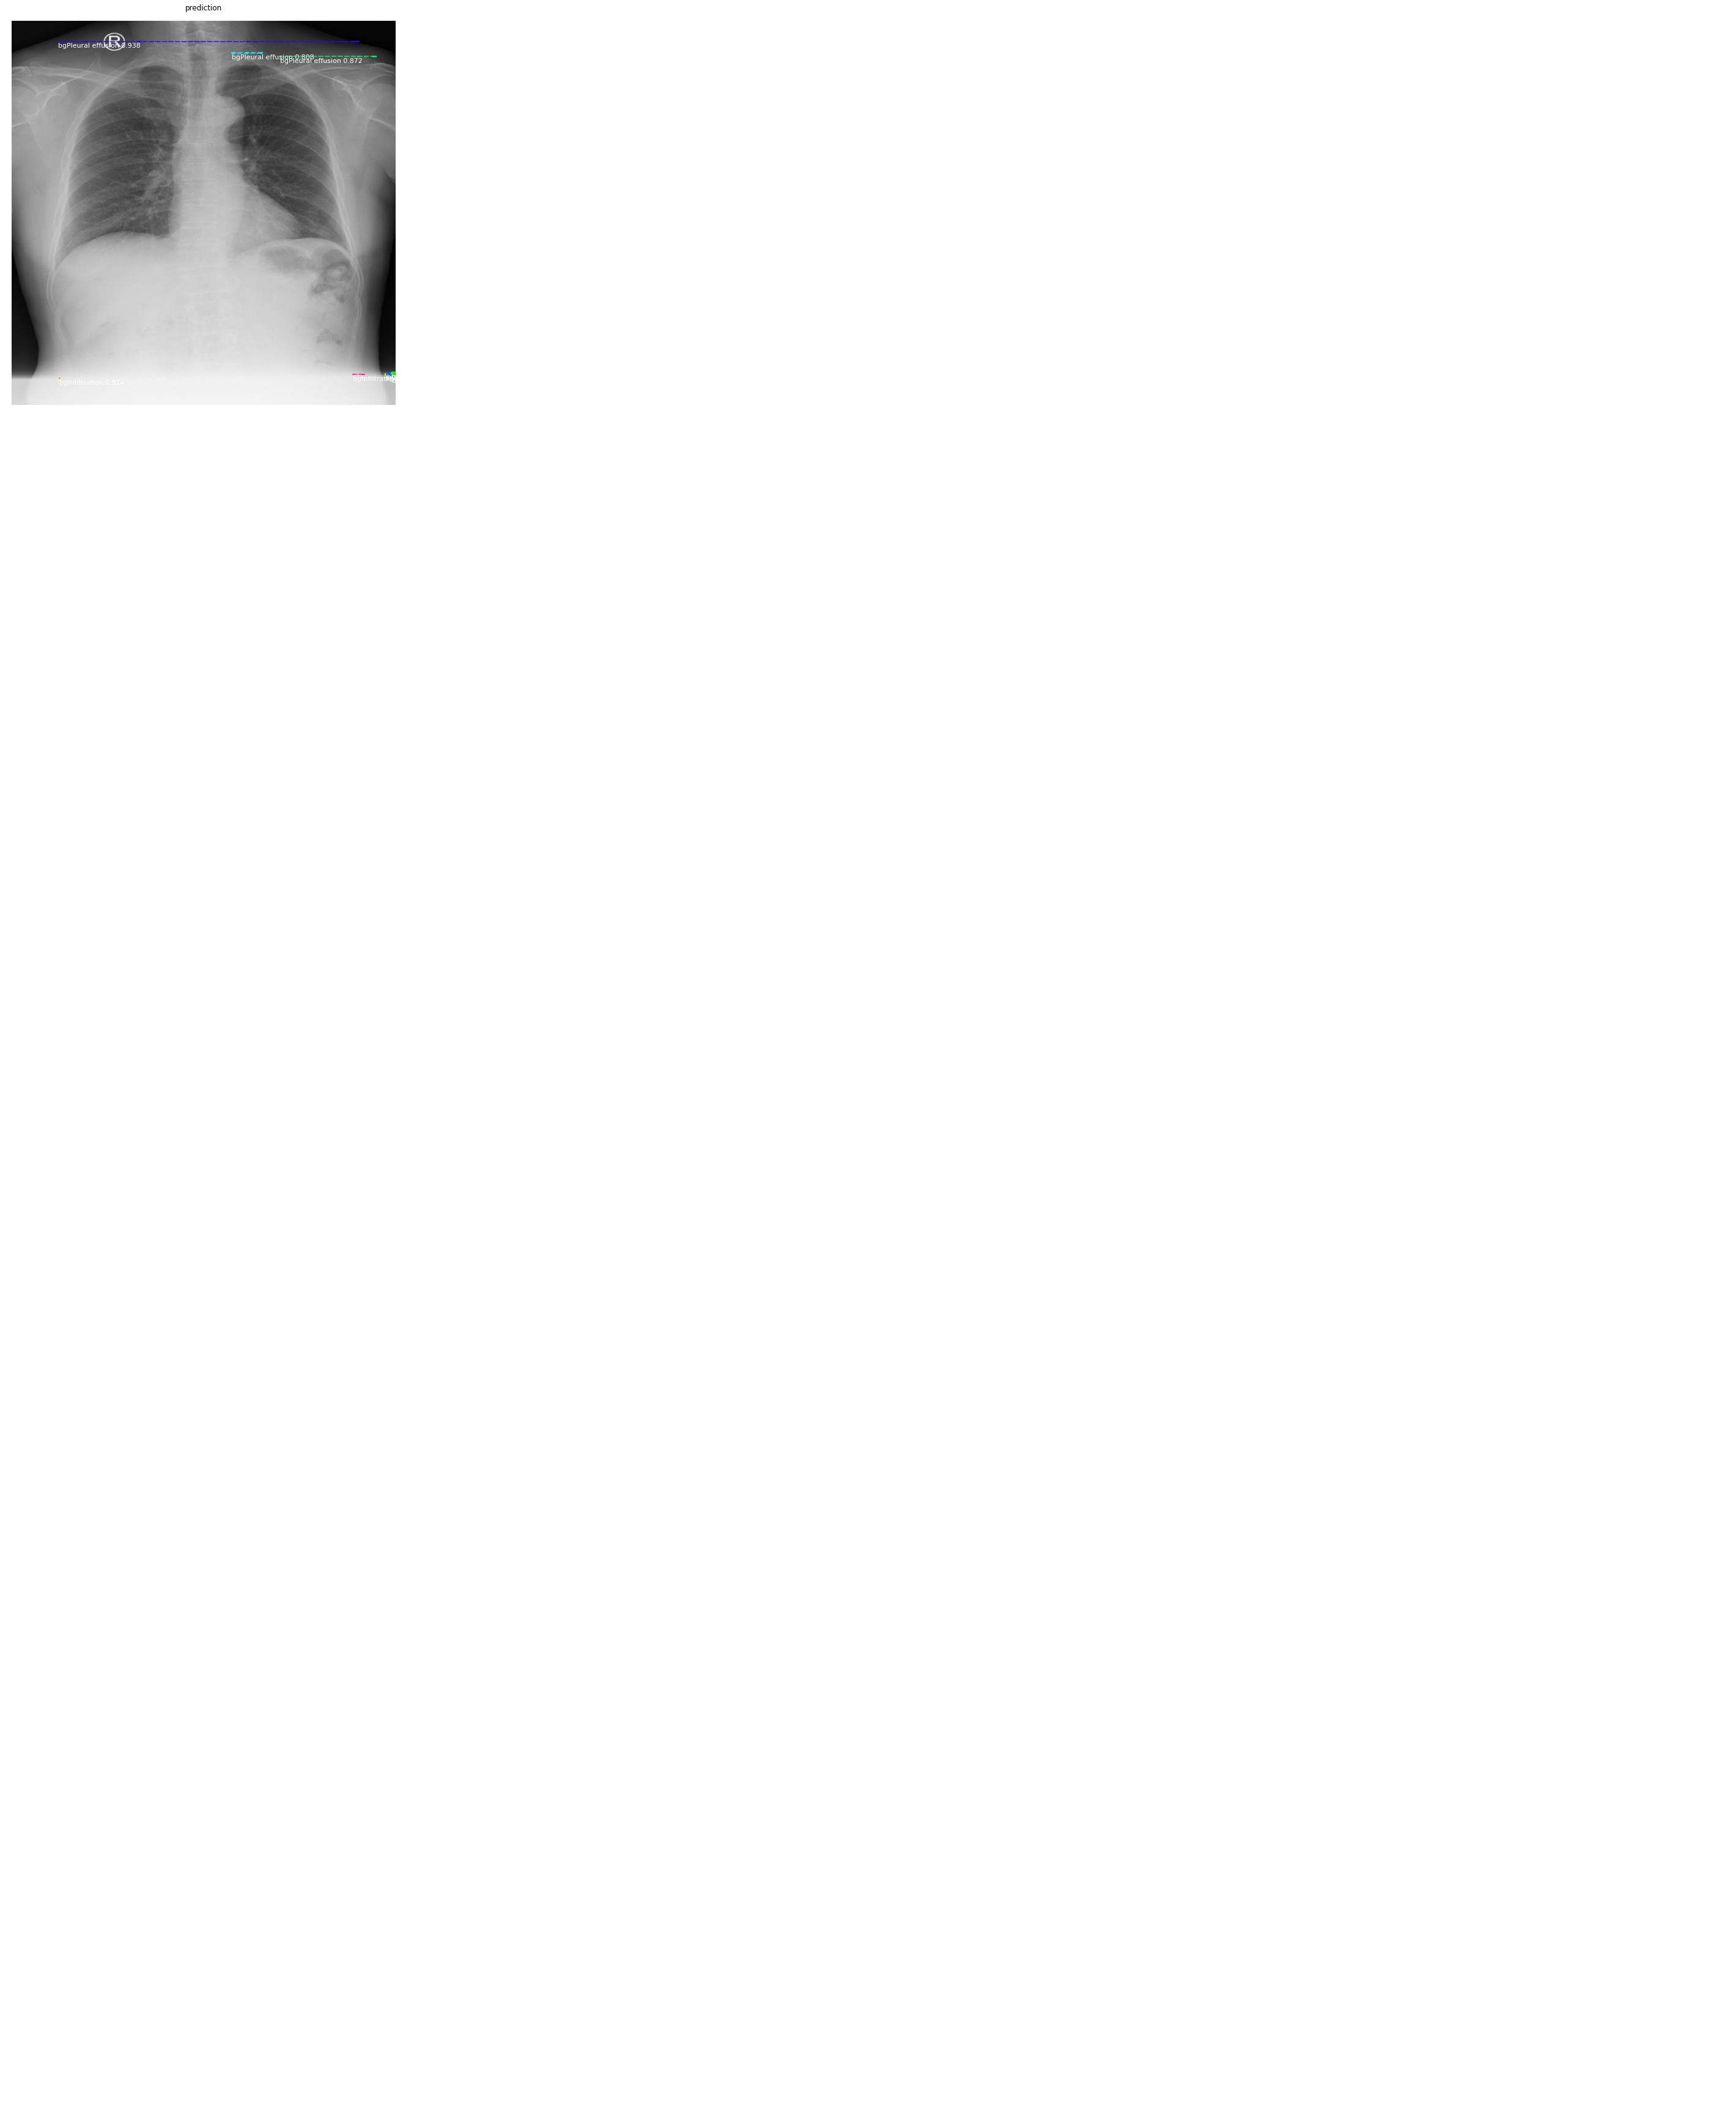

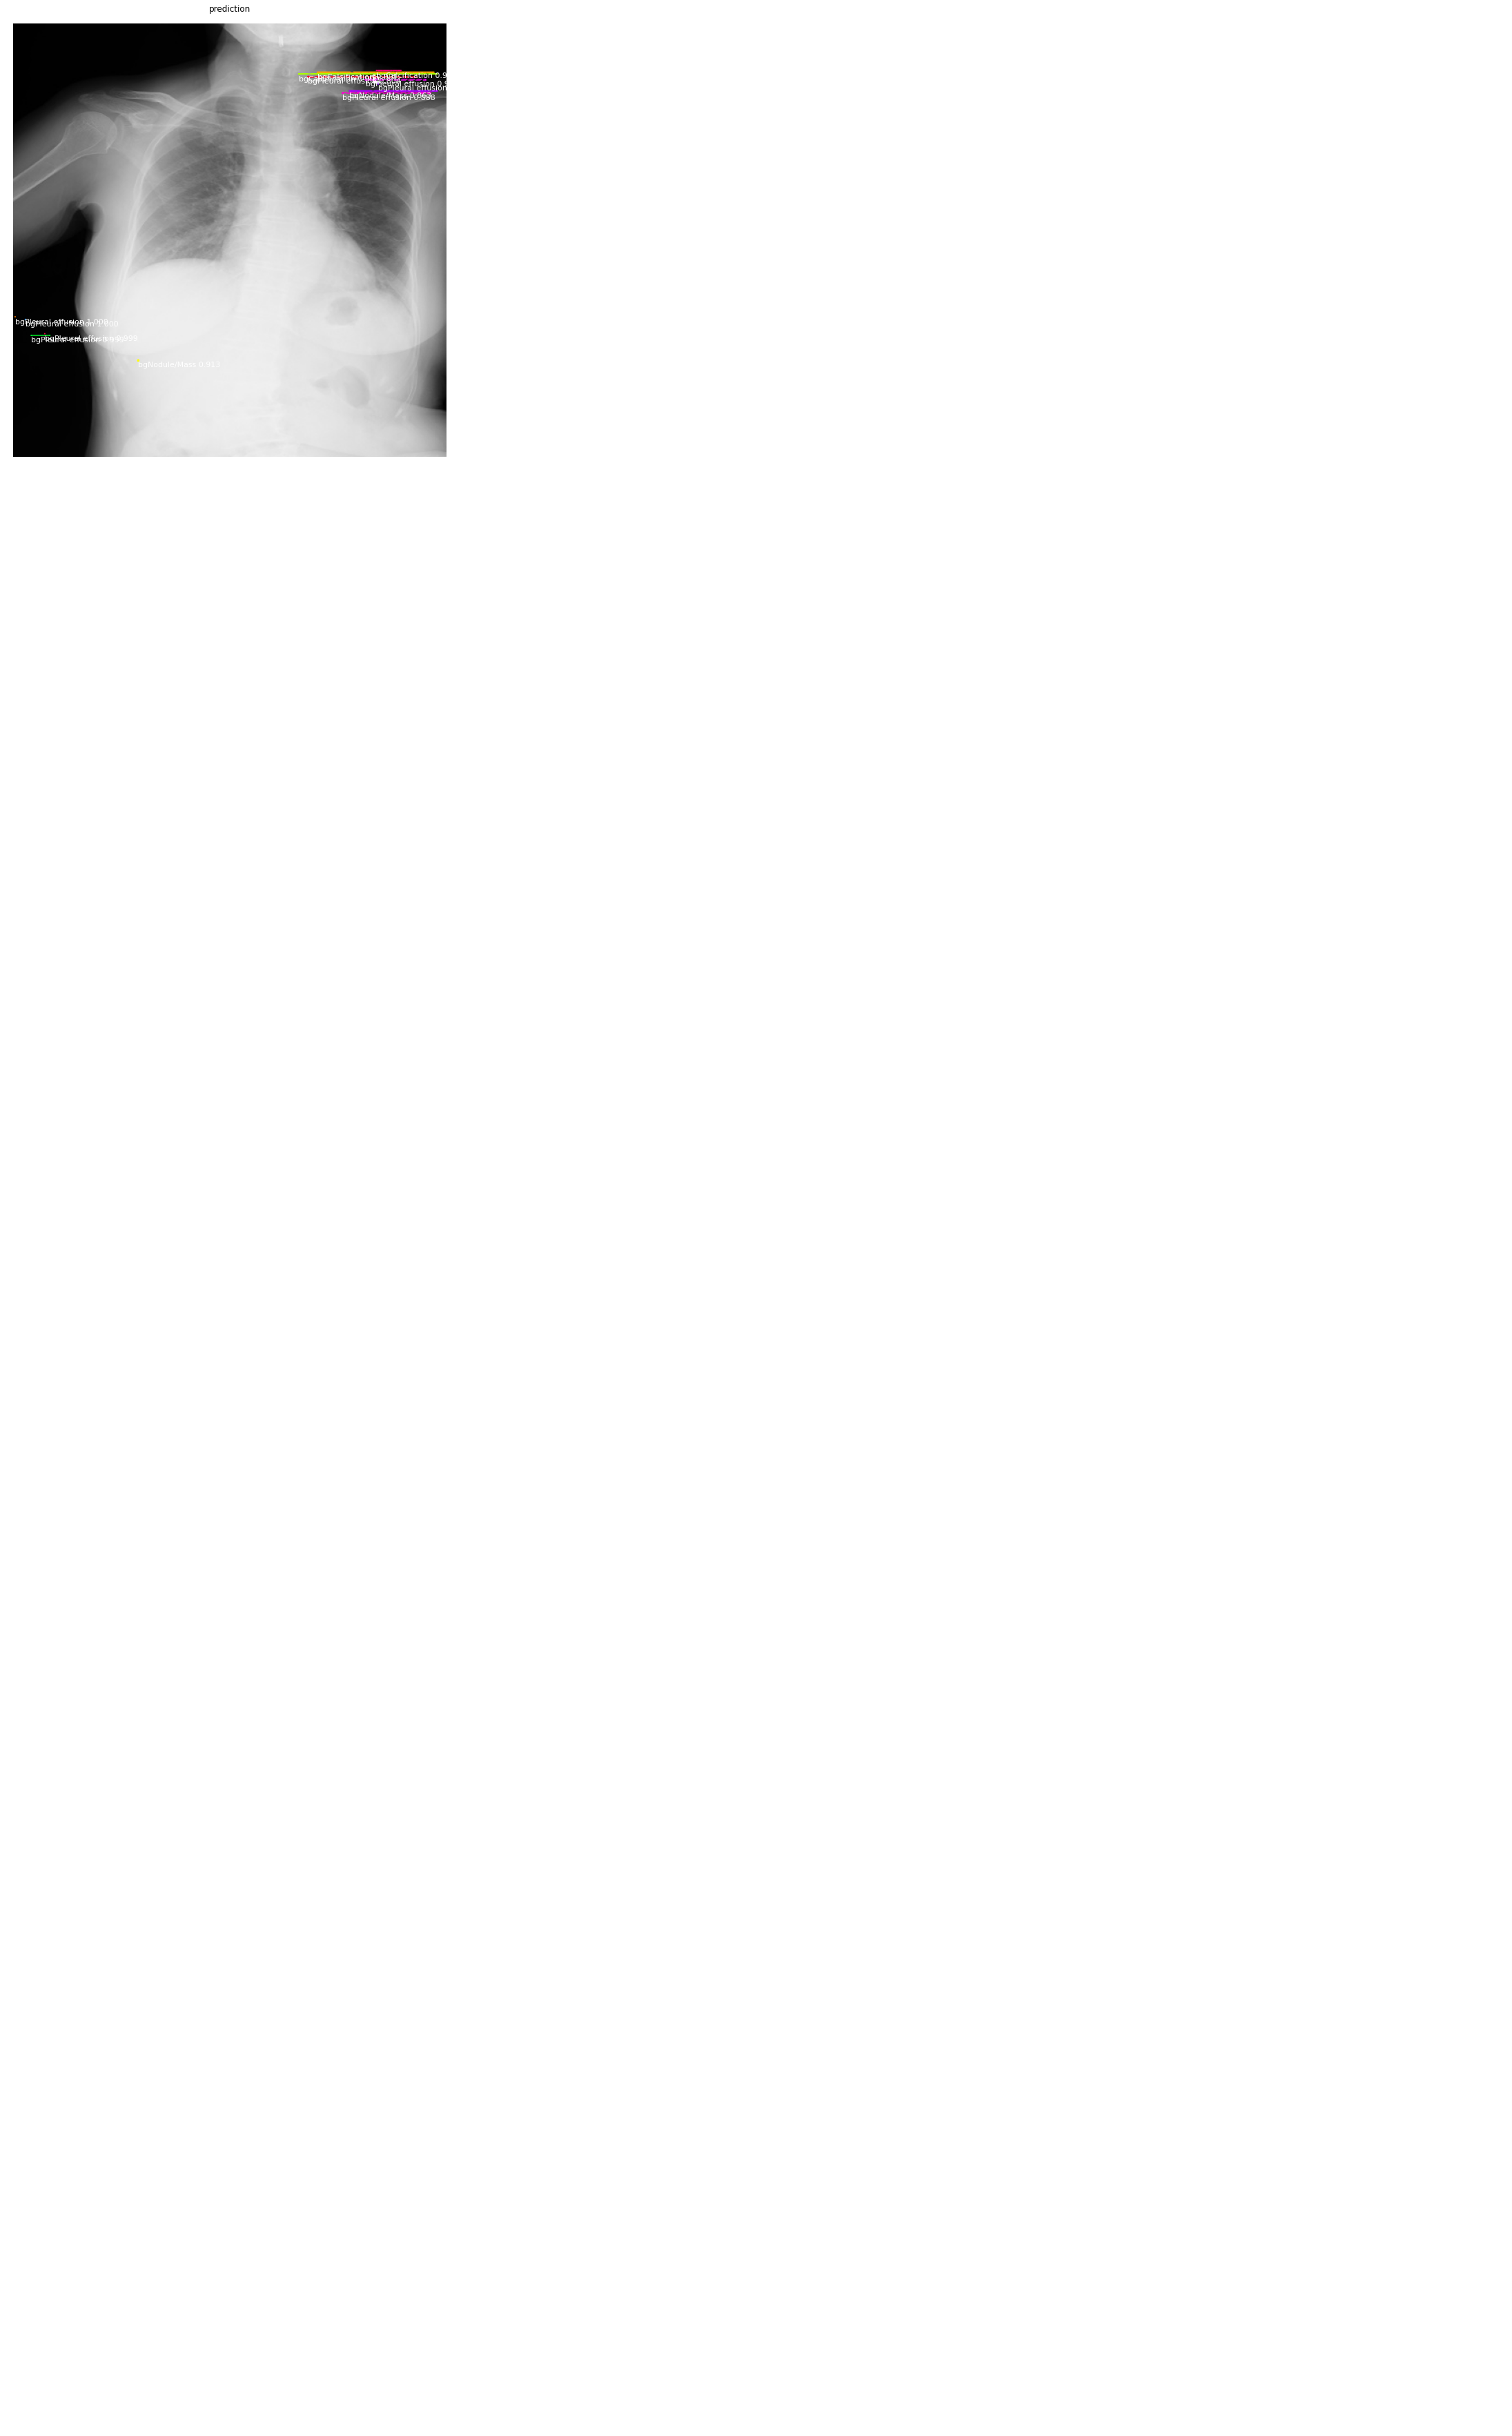

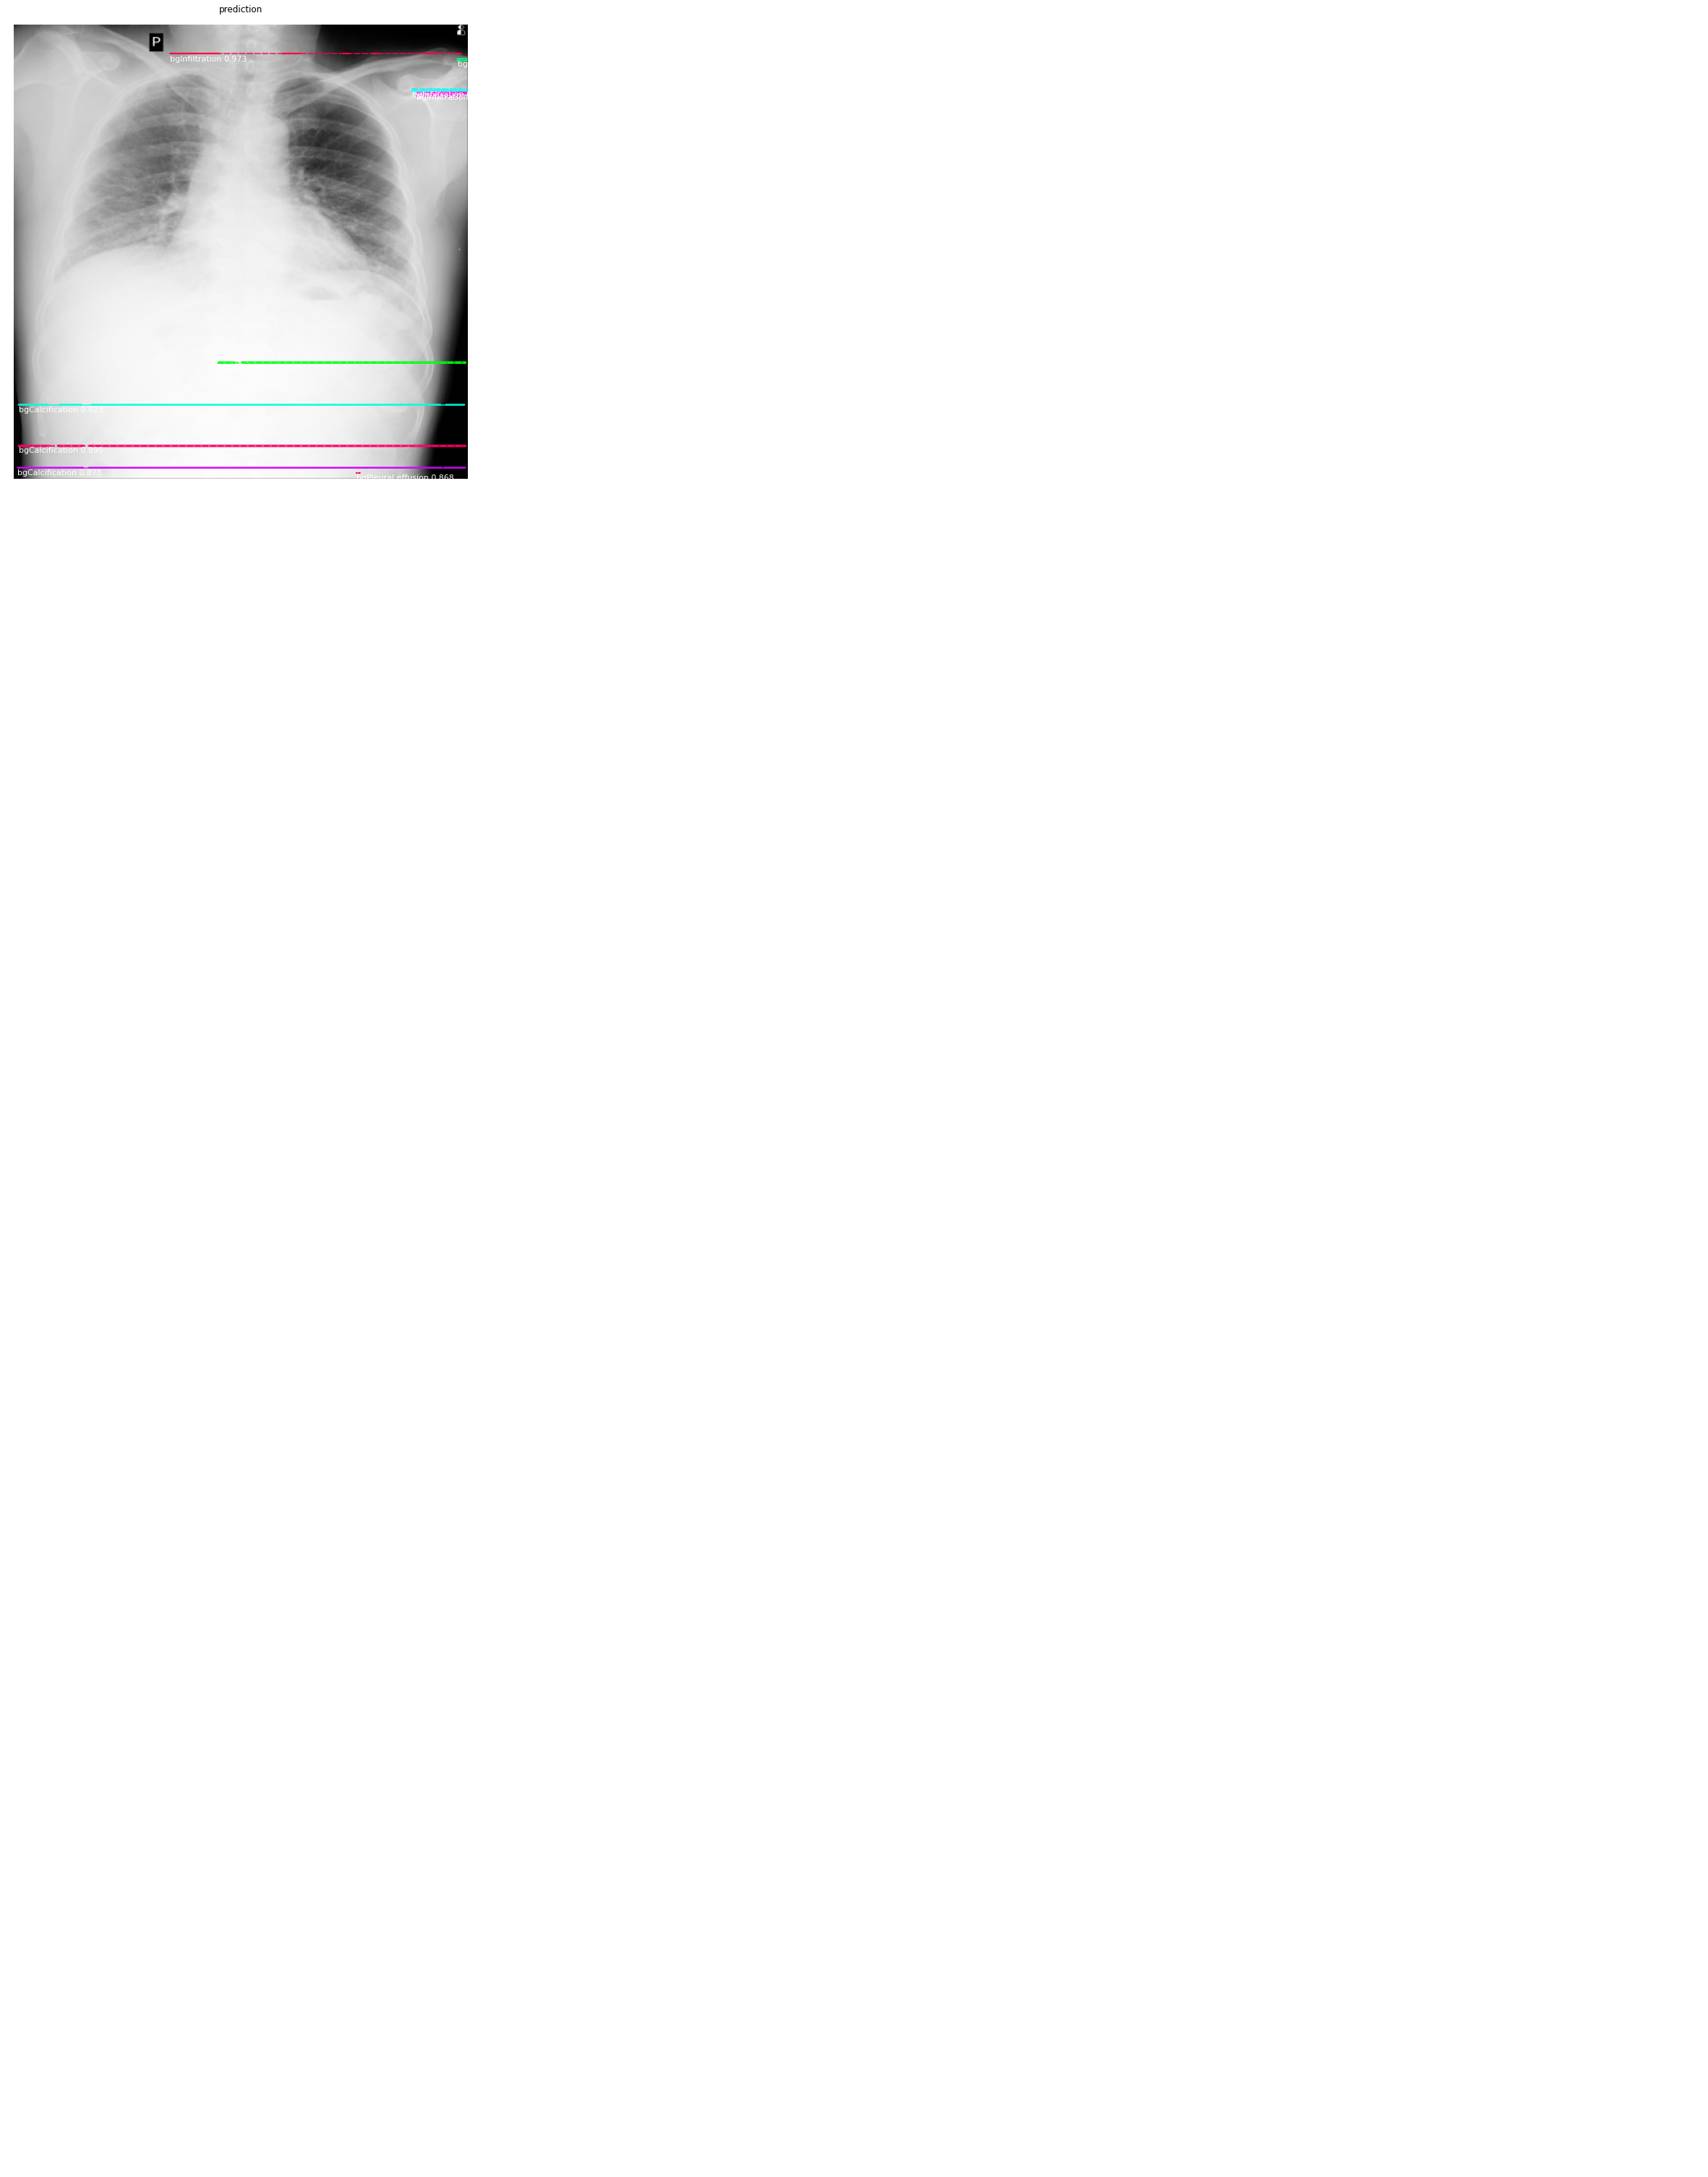

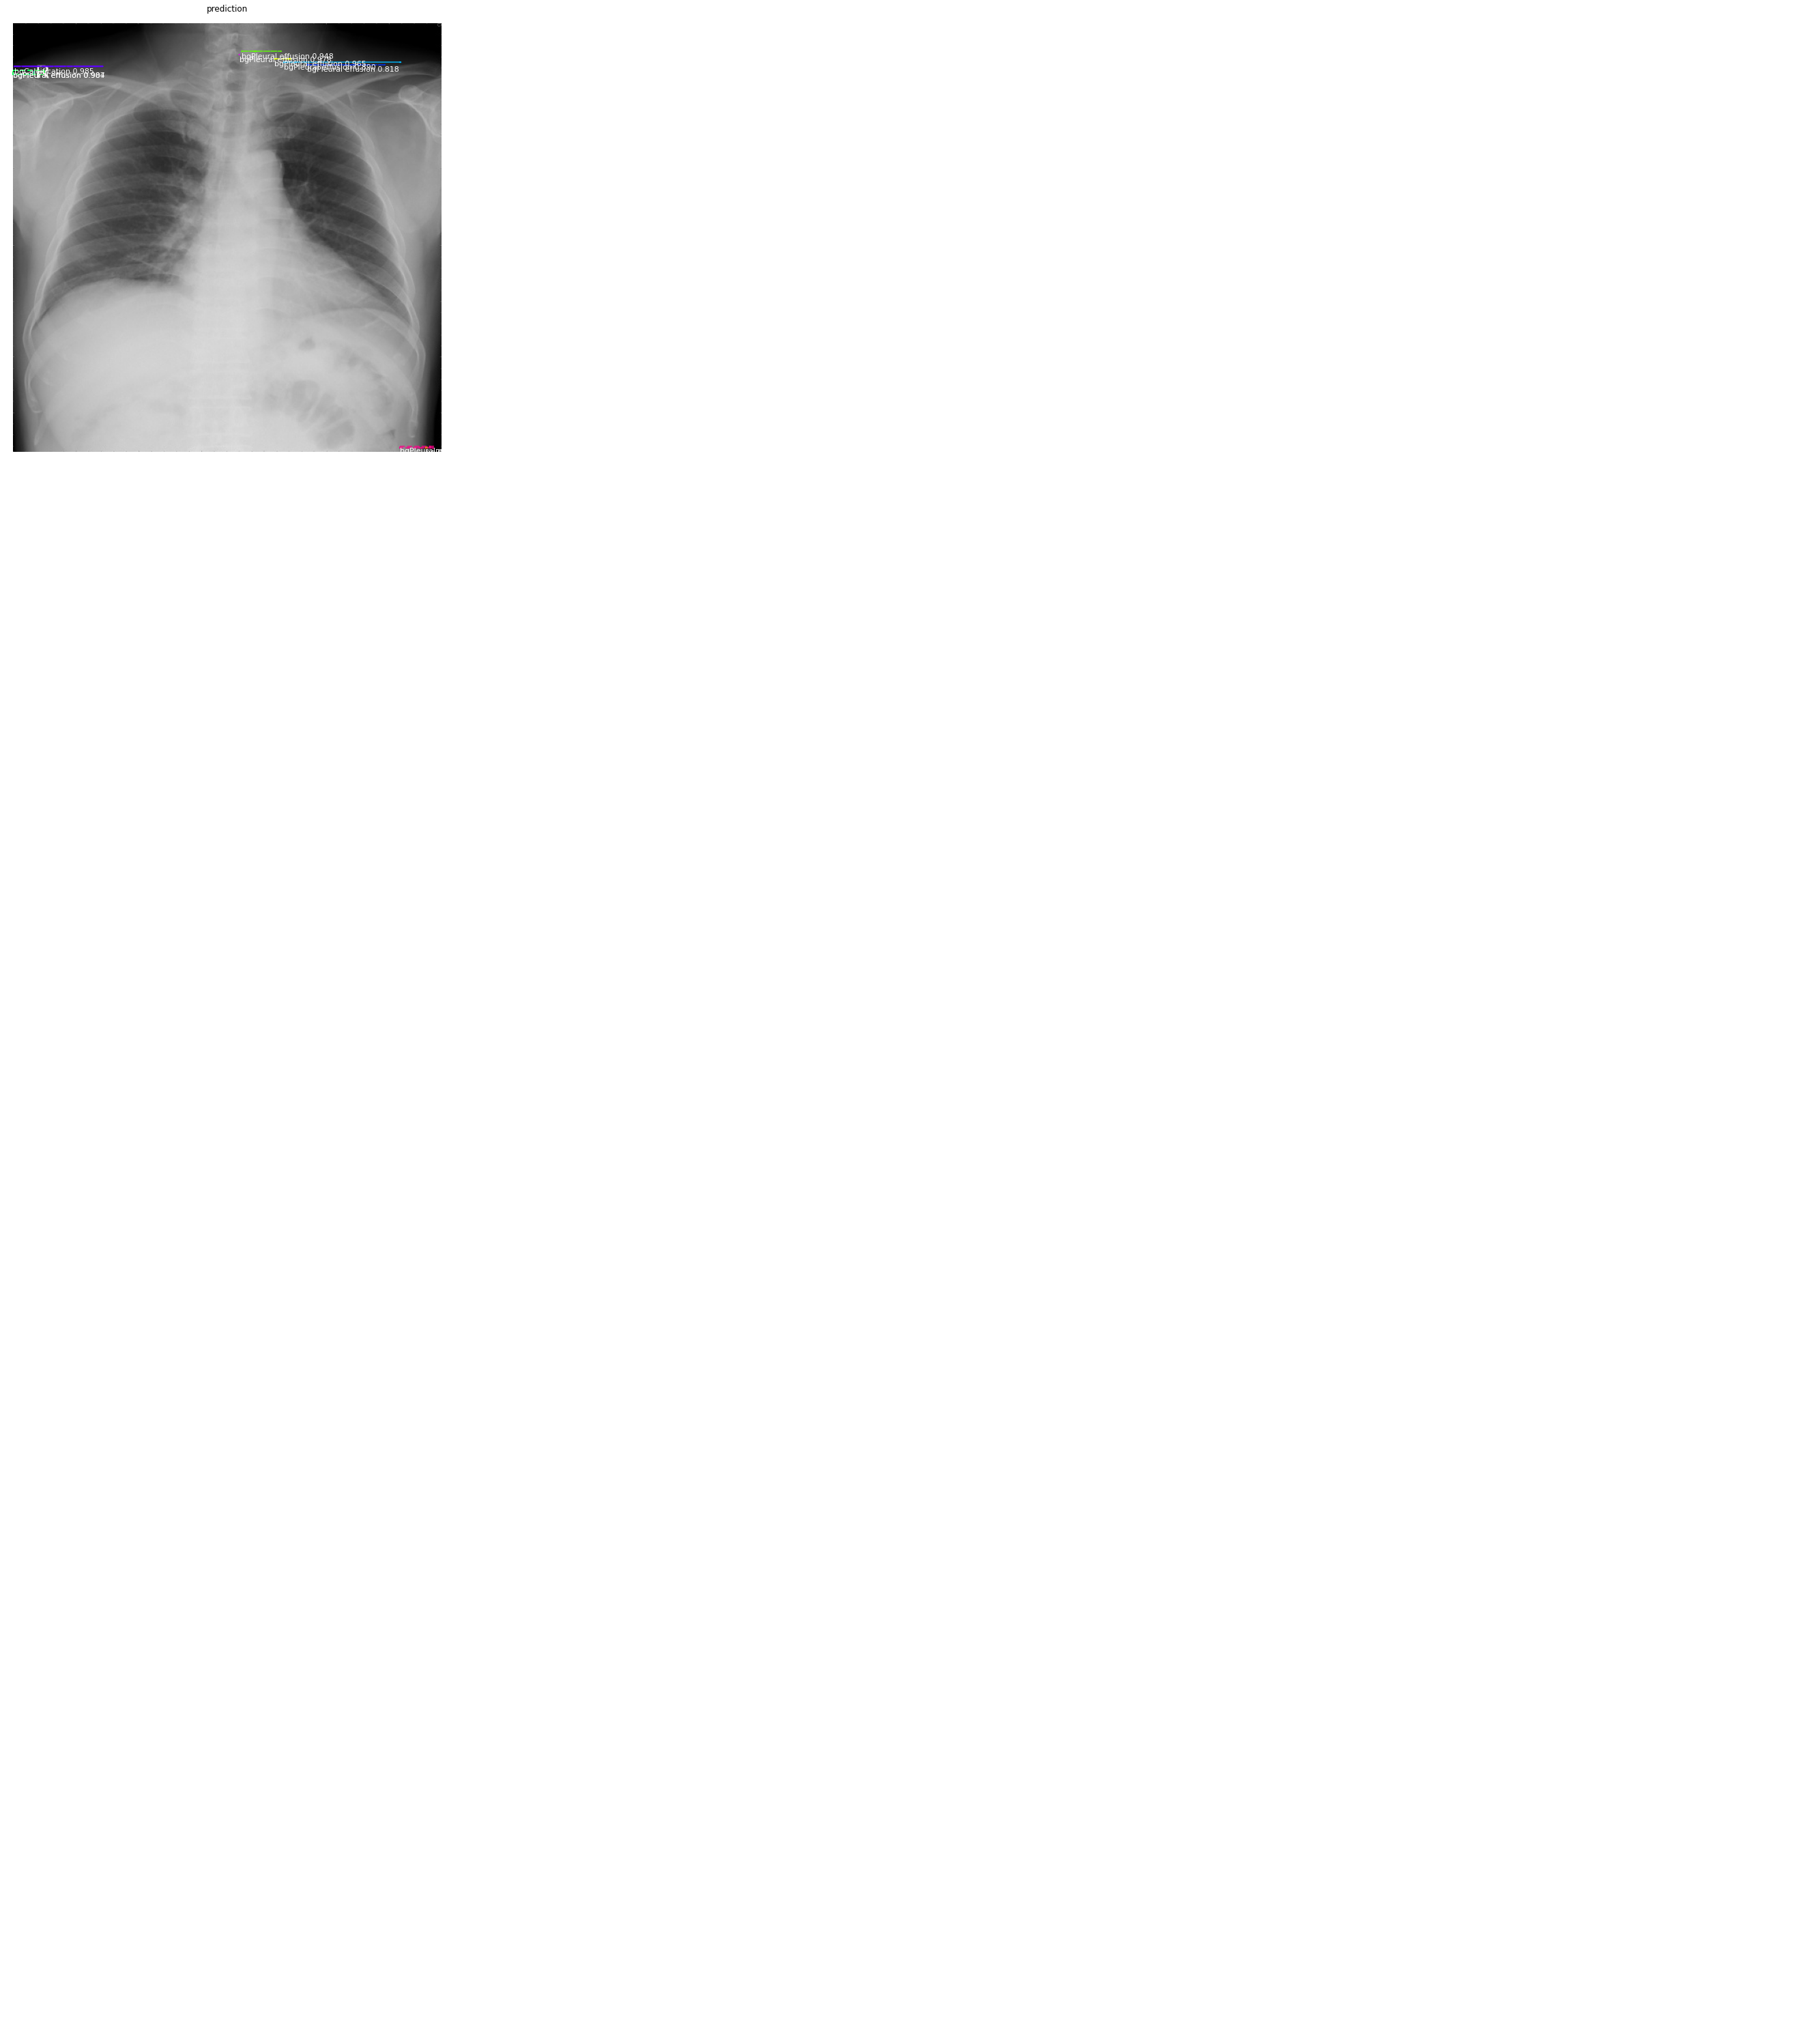

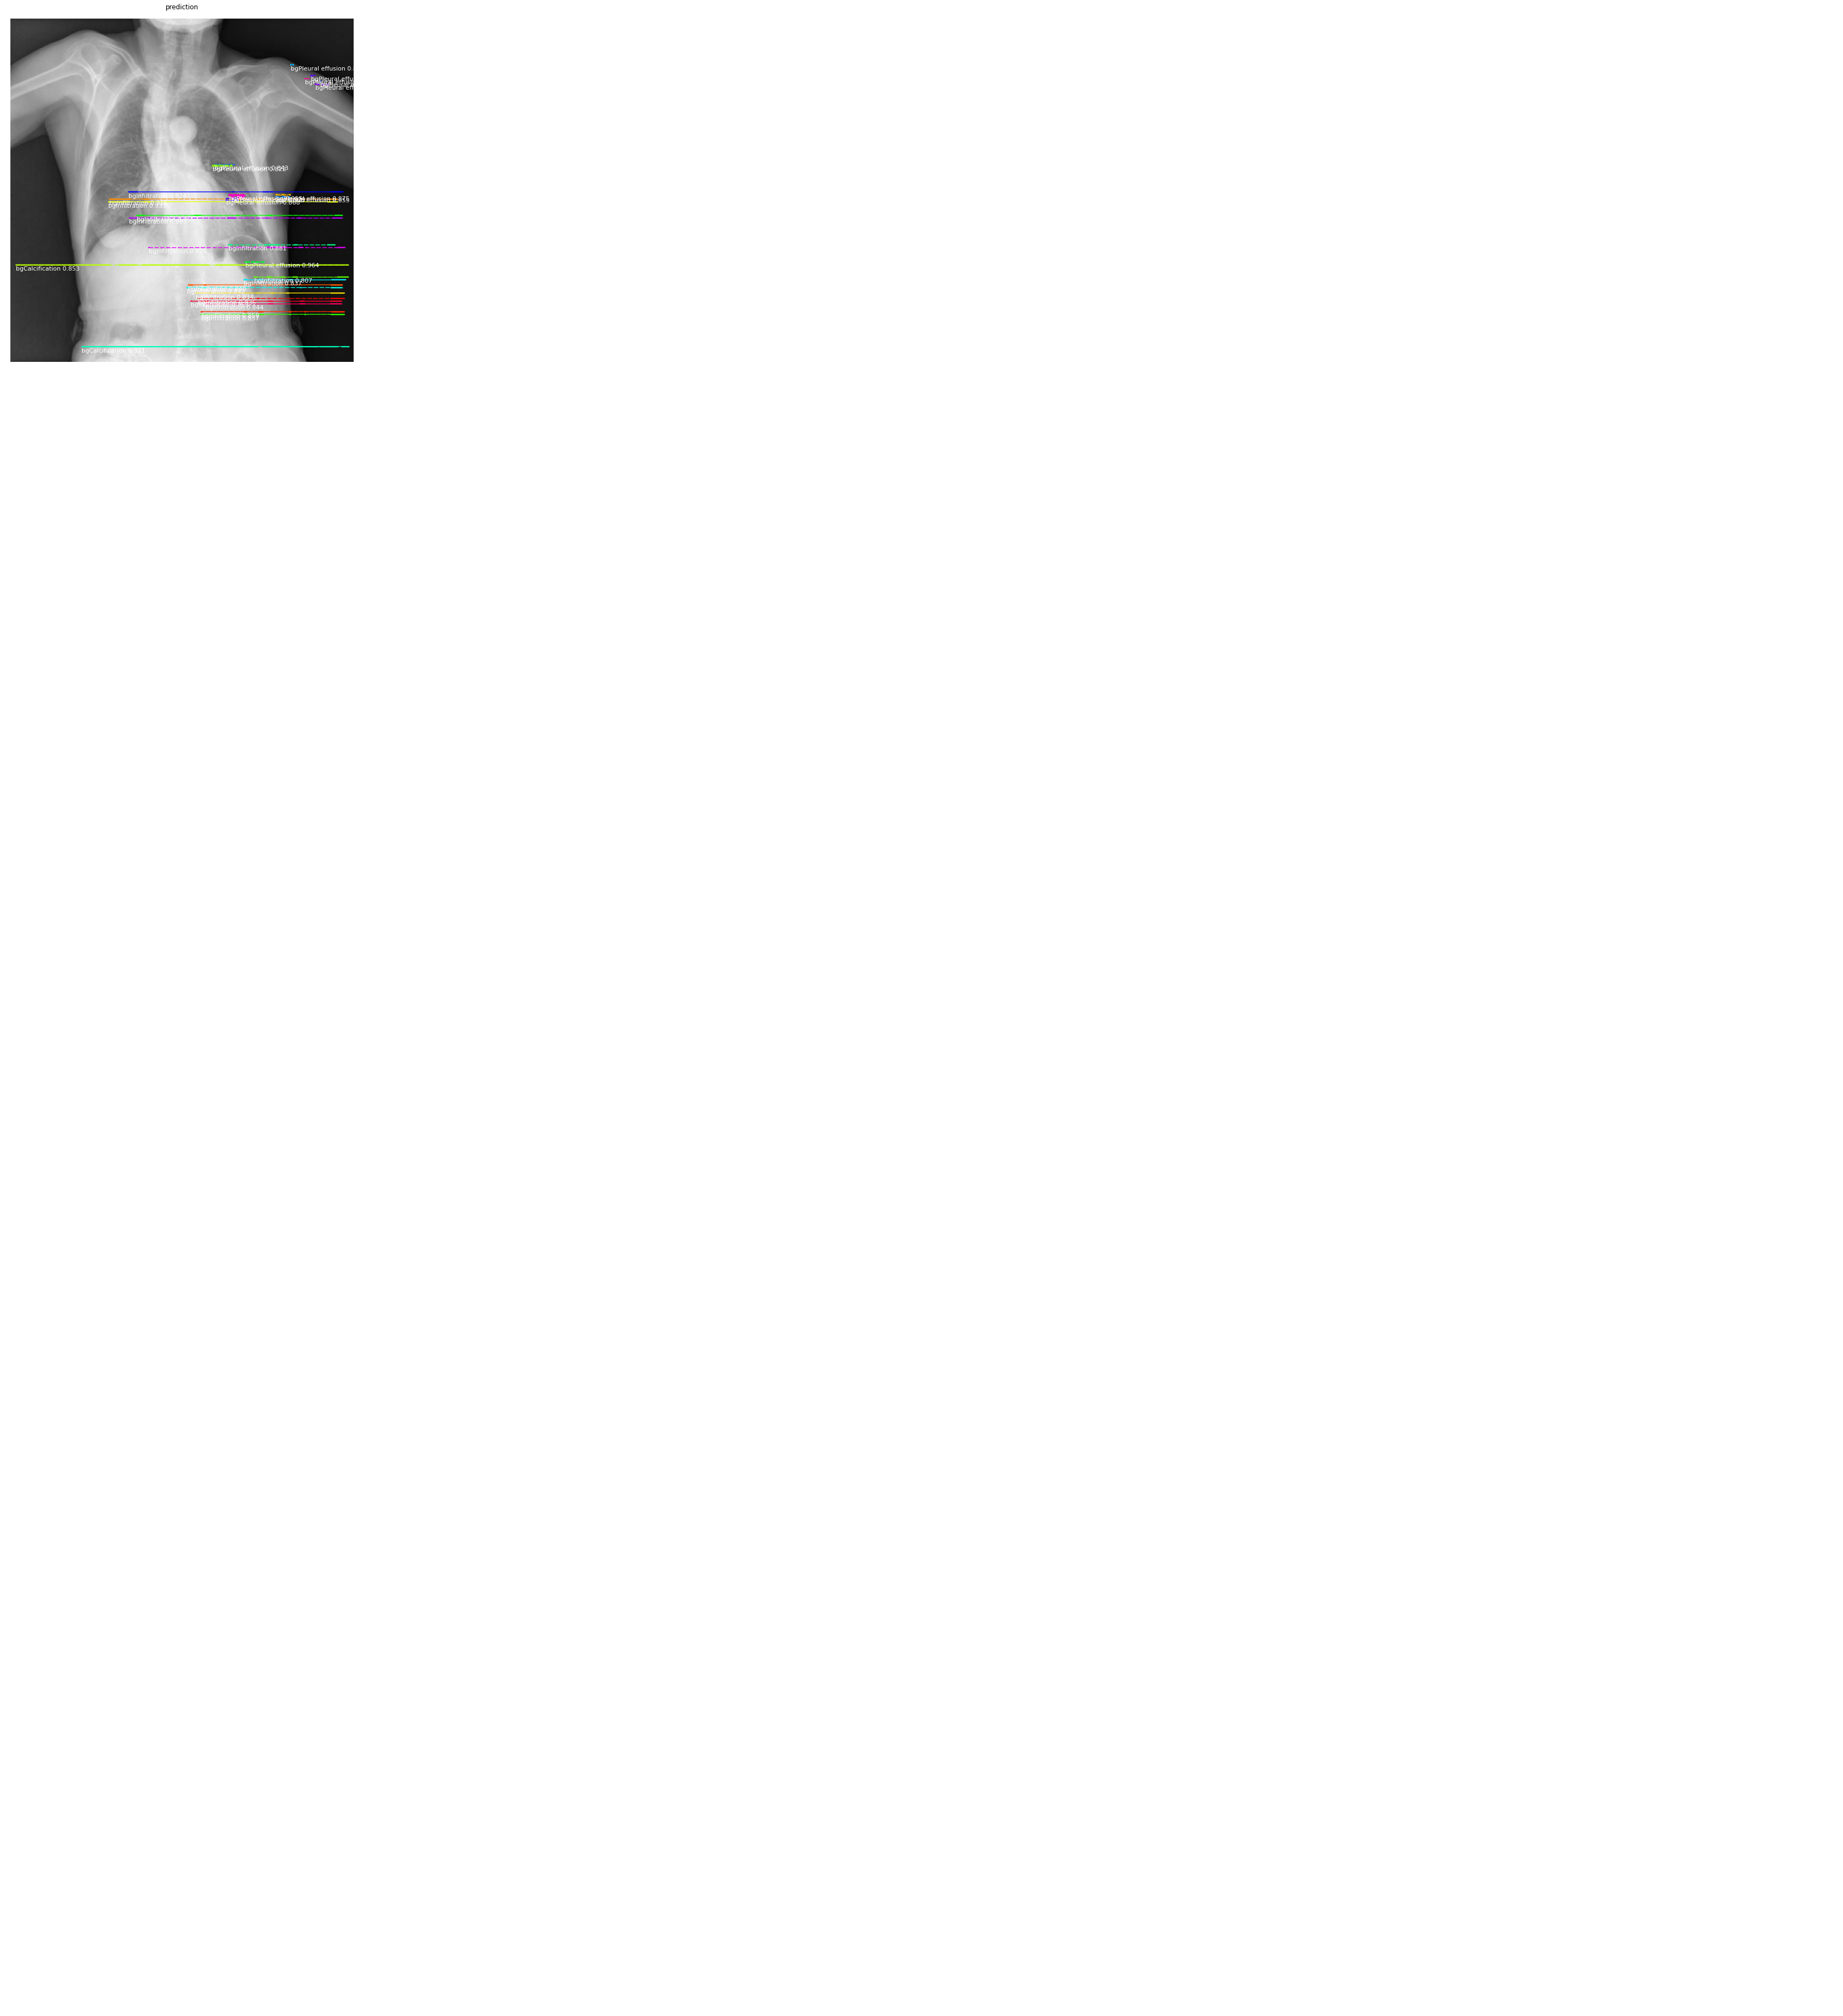

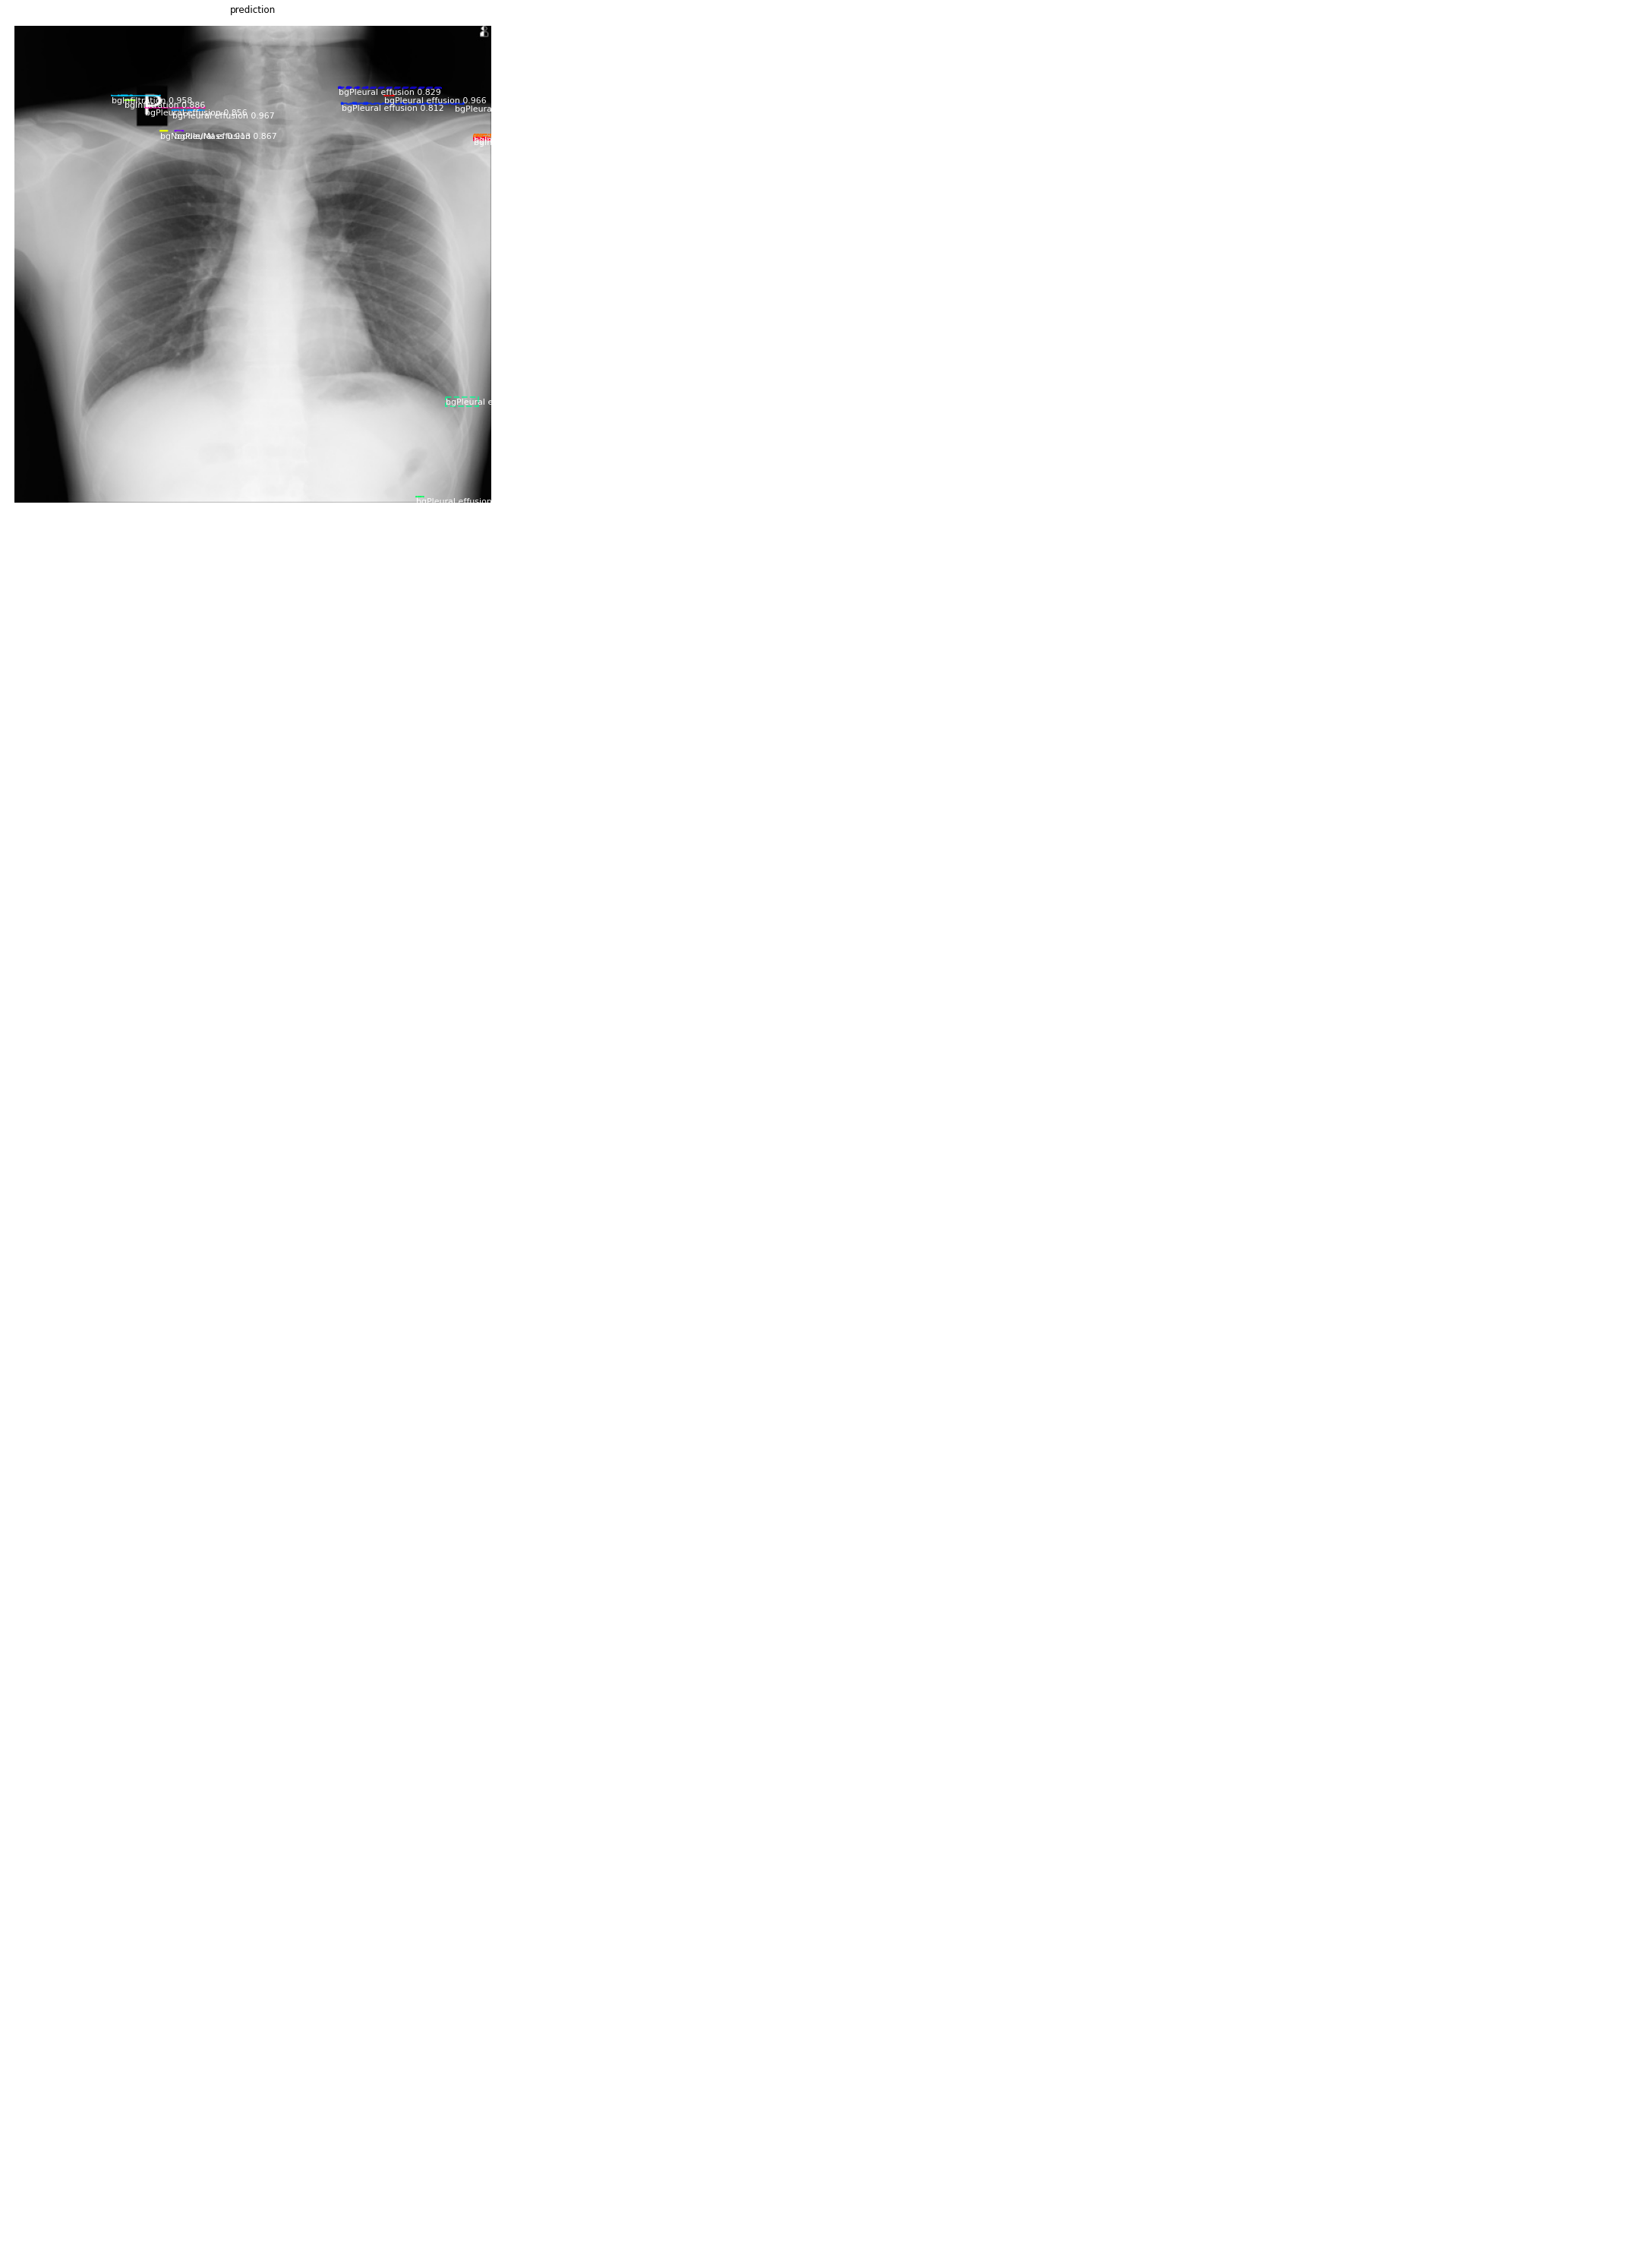

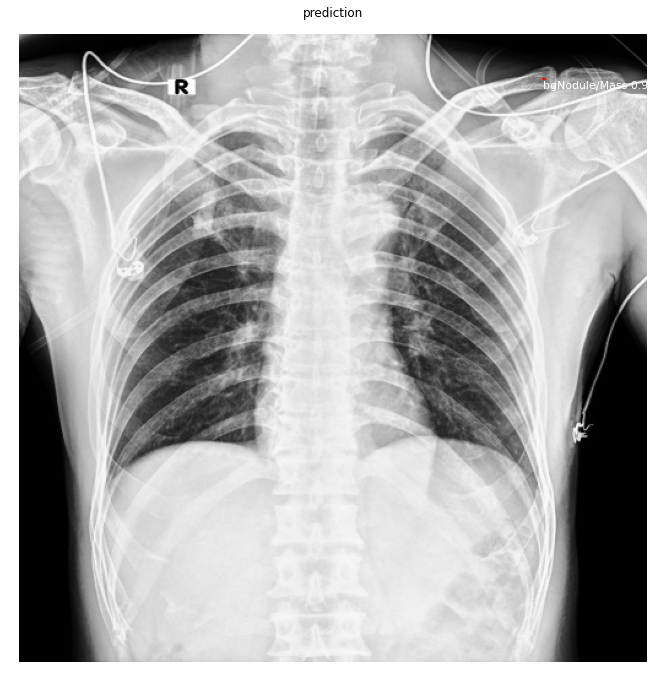

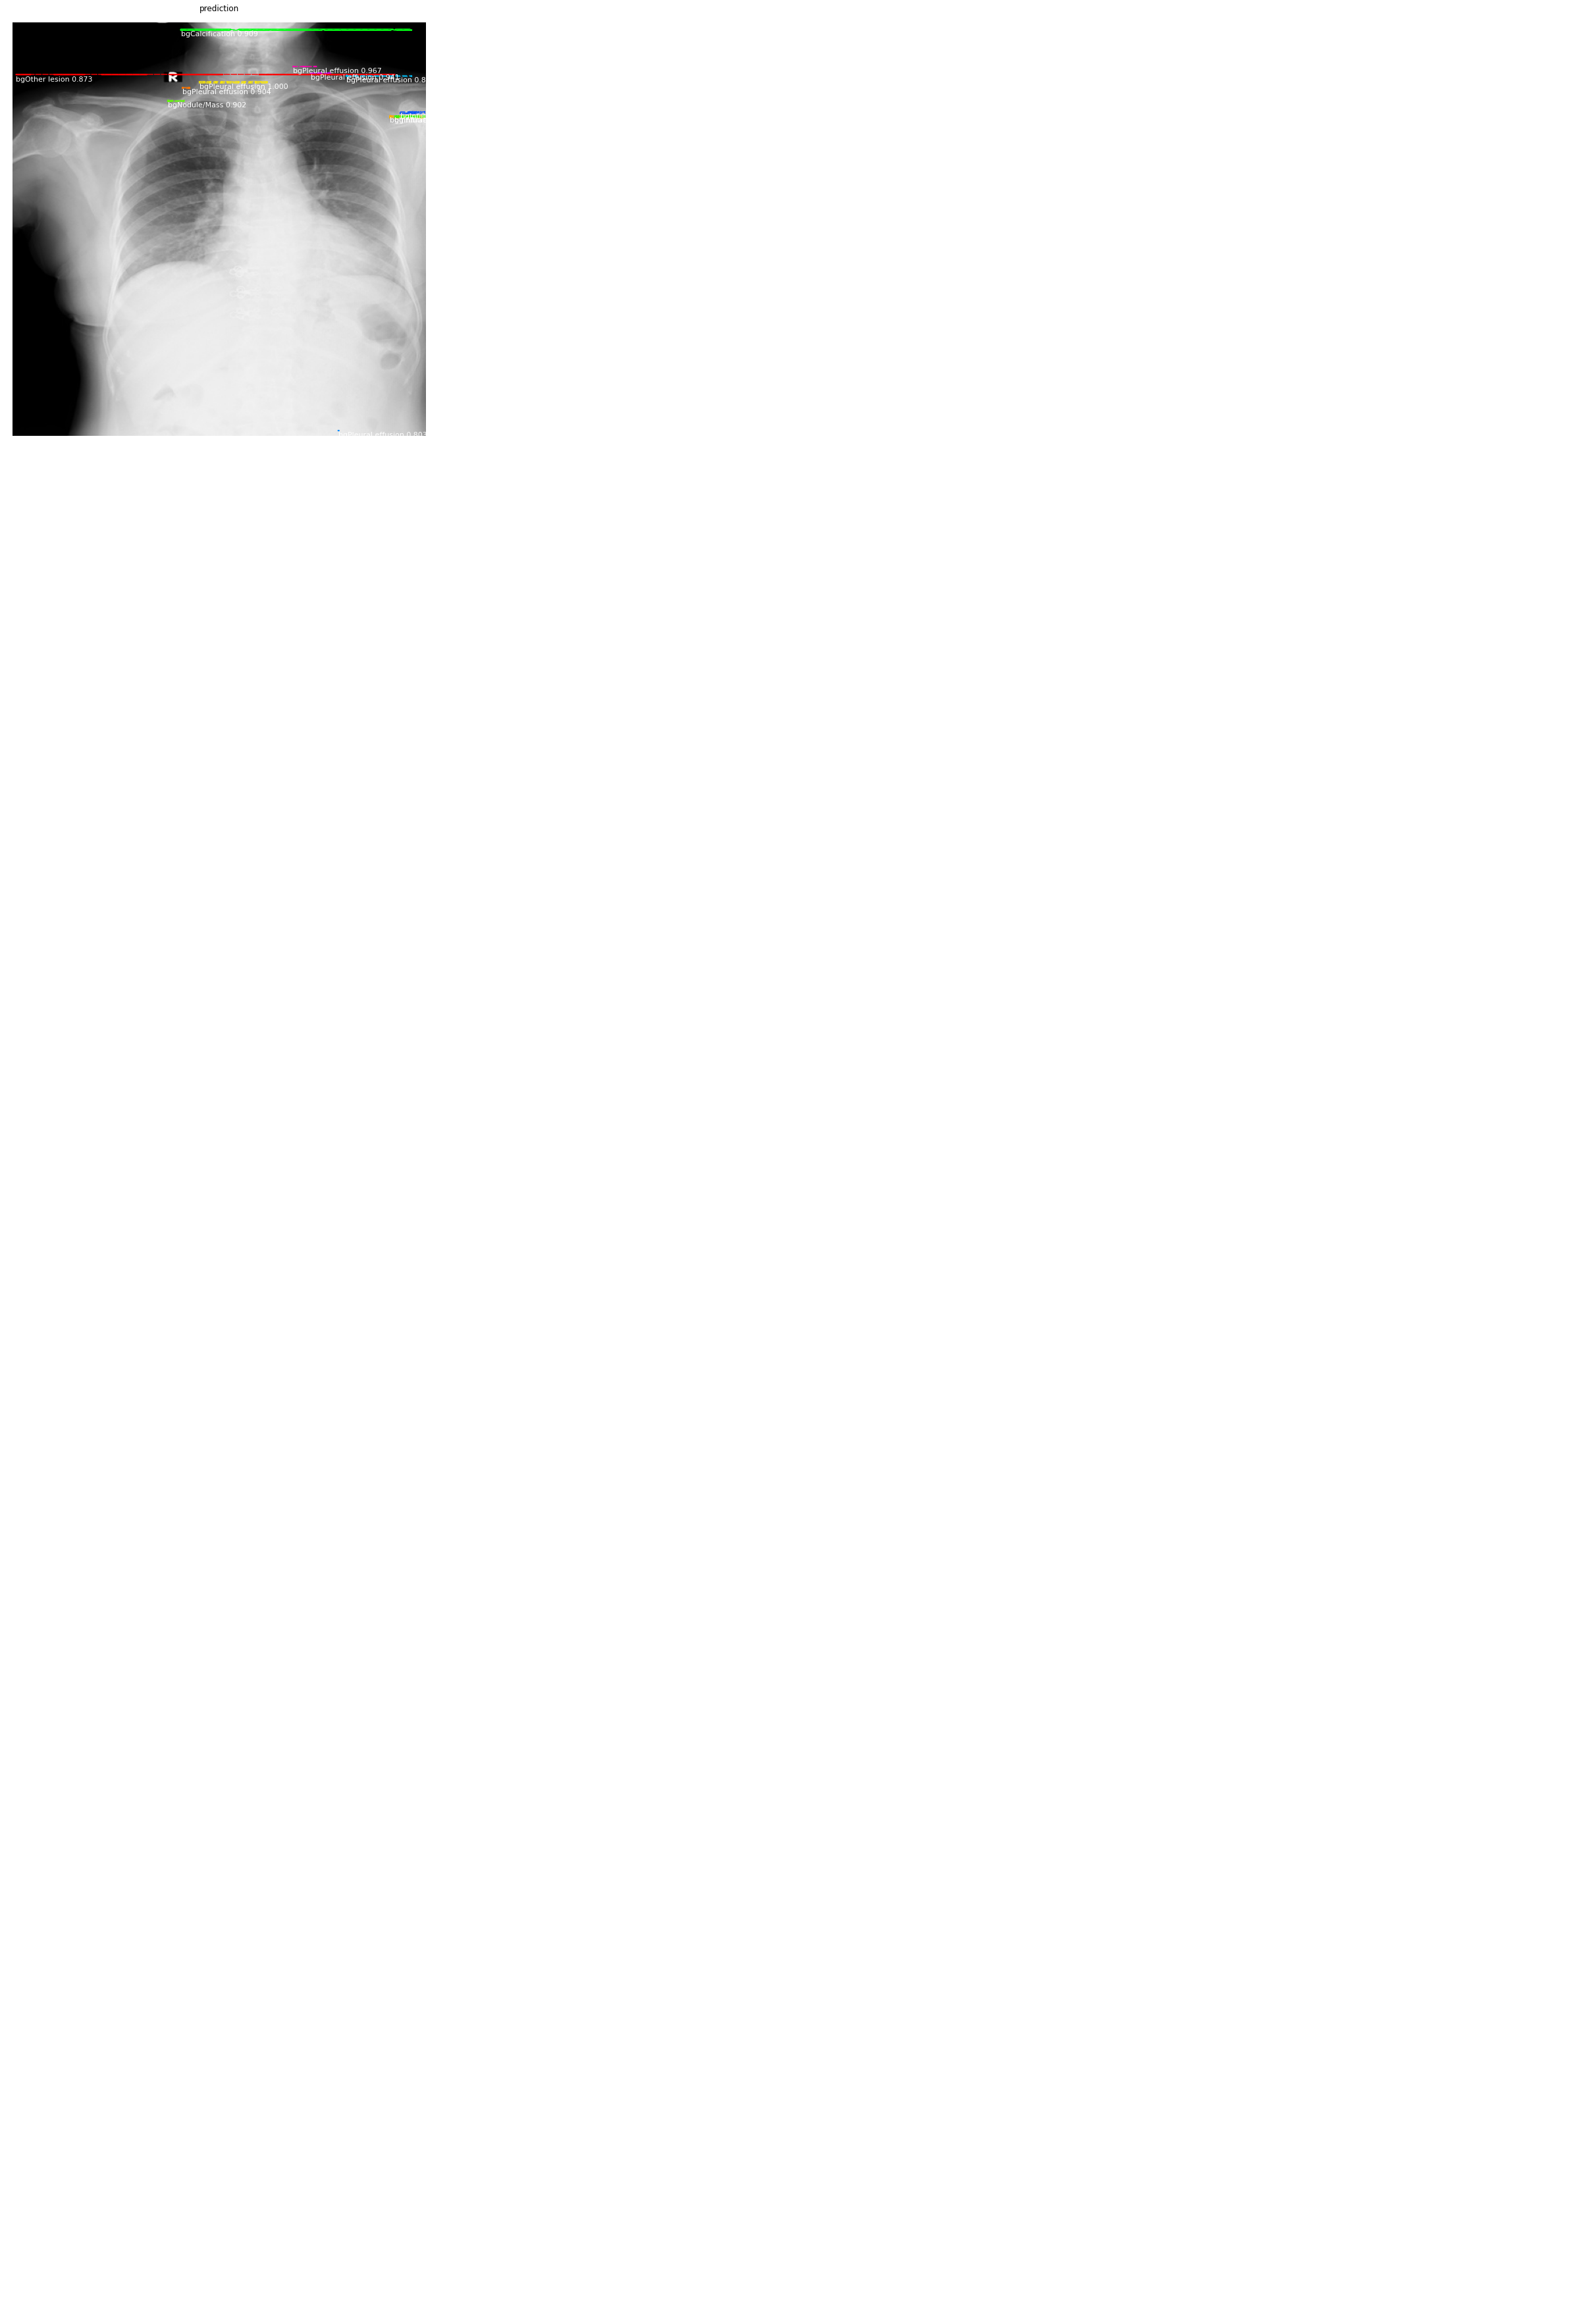

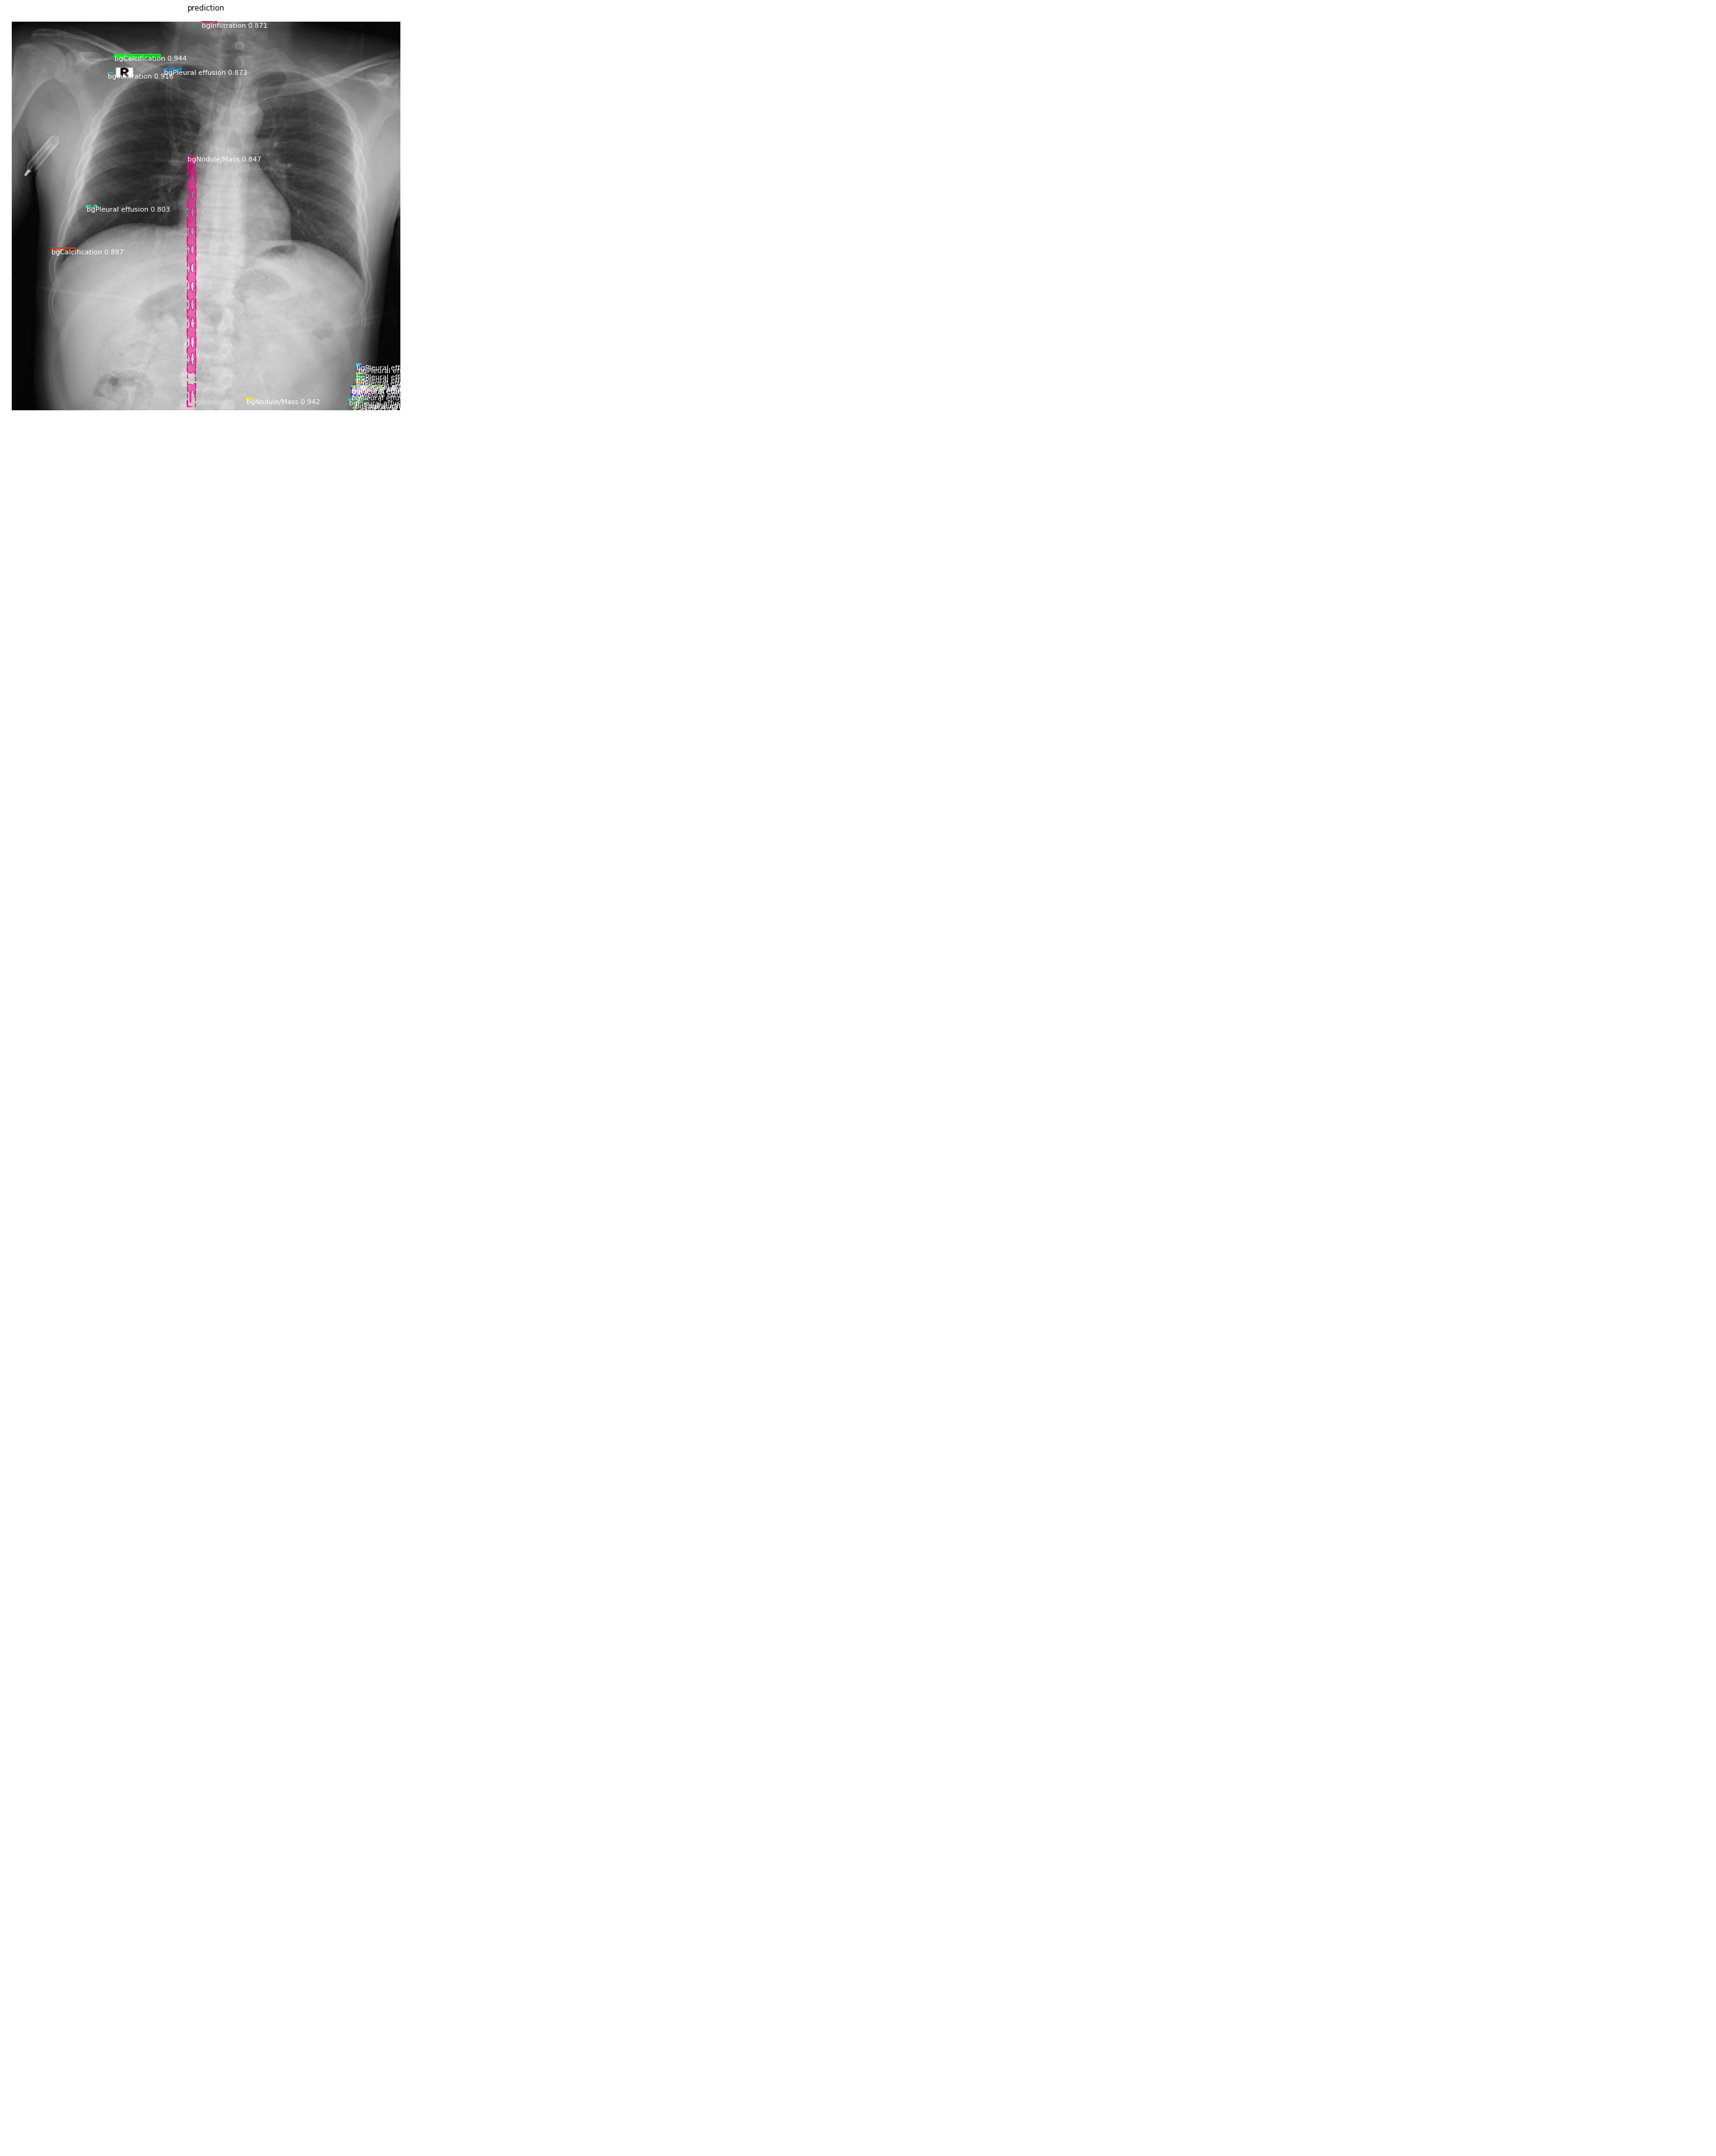

In [30]:
image_size=512
test_file_list = os.listdir(TEST_DIR)[1:10]

for test_file in test_file_list:
    dicom_image = dicom2array(TEST_DIR + '/' + test_file)
    find_anomalies(dicom_image, display=True)